# NSL-KDD Classification

## Install Dependencies

In [1]:
!pip install numpy
!pip install pandas
!pip install scikit-learn

In [2]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

## Classification Model Functions

### Function to Load the Test and Train Data

In [3]:
# Function to read and display basic info of datasets
def load_data(train_path, test_path):
    data_train = pd.read_csv(train_path)
    data_test = pd.read_csv(test_path)
    return data_train, data_test

### Function to plot the data distribution

In [4]:
# Function to plot pie chart of a categorical column
def plot_pie_chart(column_name, frame):
    if column_name not in frame.columns:
        print(f"Column '{column_name}' not found in the dataset.")
        return
    column_data = frame[column_name].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(column_data, labels=column_data.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Distribution of {column_name}')
    plt.show()

### Function to pre-process that data 

In [5]:
# Outcome mapping for the labels
outcome_mapping = {
    'normal': 0,
    'dos': 1,
    'probe': 2,
    'r2l': 3,
    'u2r': 4,
}

# Scaling function using RobustScaler
def scale_numeric_features(df_num, cols):
    std_scaler = RobustScaler()
    std_scaler_temp = std_scaler.fit_transform(df_num)
    return pd.DataFrame(std_scaler_temp, columns=cols)

# Function to preprocess the data
def preprocess(dataframe, cat_cols):
    df = dataframe.copy()
    df_num = df.drop(cat_cols, axis=1)
    num_cols = df_num.columns
    scaled_df = scale_numeric_features(df_num, num_cols)

    df.drop(labels=num_cols, axis="columns", inplace=True)
    df[num_cols] = scaled_df[num_cols]
    
    # Map label column based on the outcome_mapping
    df['label'] = df['label'].map(outcome_mapping)
    
    # One-hot encode categorical columns
    df = pd.get_dummies(df, columns=['protocol_type', 'service', 'flag'], drop_first=True)
    
    return df

## Evaluation Function for F1 Accuracy and G-Mean Score

In [6]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

def evaluate_classification(model, model_name, x_train, x_test, y_train, y_test, metrics_dict):
    """
    Evaluate a classification model using multiple metrics: F1 score, accuracy, and G-mean.
    
    Parameters:
    -----------
    model : sklearn classifier object
        The trained classification model
    model_name : str
        Name of the model for printing and storing results
    x_train : array-like
        Training features
    x_test : array-like
        Test features
    y_train : array-like
        Training labels
    y_test : array-like
        Test labels
    metrics_dict : dict
        Dictionary to store the evaluation metrics
        
    Returns:
    --------
    dict
        Updated metrics dictionary with new model results
    """
    # Make predictions
    y_pred = model.predict(x_test)
    
    # Calculate metrics
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    
    # Calculate G-mean
    # For each class, calculate the sensitivity (true positive rate)
    sensitivities = []
    classes = np.unique(y_test)
    
    for cls in classes:
        cls_idx = (y_test == cls)
        if np.any(cls_idx):  # Only calculate if class exists in test set
            true_pos = np.sum((y_test == cls) & (y_pred == cls))
            total_pos = np.sum(y_test == cls)
            sensitivity = true_pos / total_pos if total_pos > 0 else 0
            sensitivities.append(sensitivity)
    
    # G-mean is the geometric mean of sensitivities
    g_mean = np.prod(sensitivities) ** (1/len(sensitivities))
    
    # Store metrics in dictionary
    metrics_dict[model_name] = {
        'F1 Score': f1,
        'Accuracy': accuracy,
        'G-mean': g_mean
    }
    
    # Print results
    print(f"\nResults for {model_name}:")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"G-mean Score: {g_mean:.4f}")
    
    return metrics_dict

## Main Function for Running and Testing models

In [7]:
def main(train_path, test_path):
    # Load the data
    data_train, data_test = load_data(train_path, test_path)

    plot_pie_chart('label', data_train)
    
    # Preprocess datasets and align columns
    cat_cols = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', 'label']
    scaled_train = preprocess(data_train, cat_cols)
    scaled_test = preprocess(data_test, cat_cols)
    scaled_test = scaled_test.reindex(columns=scaled_train.columns, fill_value=0)

    # Separate features and labels
    x_train = scaled_train.drop(['label'], axis=1).values
    y_train = scaled_train['label'].values
    x_test = scaled_test.drop(['label'], axis=1).values
    y_test = scaled_test['label'].values

    # Dictionary to store evaluation metrics for each model
    kernal_evals = {}

    # Example of using the evaluation function
    lin_svc = svm.LinearSVC().fit(x_train, y_train)
    evaluate_classification(lin_svc, "Linear SVC", x_train, x_test, y_train, y_test, kernal_evals)
    
    dt = DecisionTreeClassifier().fit(x_train, y_train)
    evaluate_classification(dt, "Decision Tree", x_train, x_test, y_train, y_test, kernal_evals)

    rf = RandomForestClassifier().fit(x_train, y_train)
    evaluate_classification(rf, "Random Forest", x_train, x_test, y_train, y_test, kernal_evals)

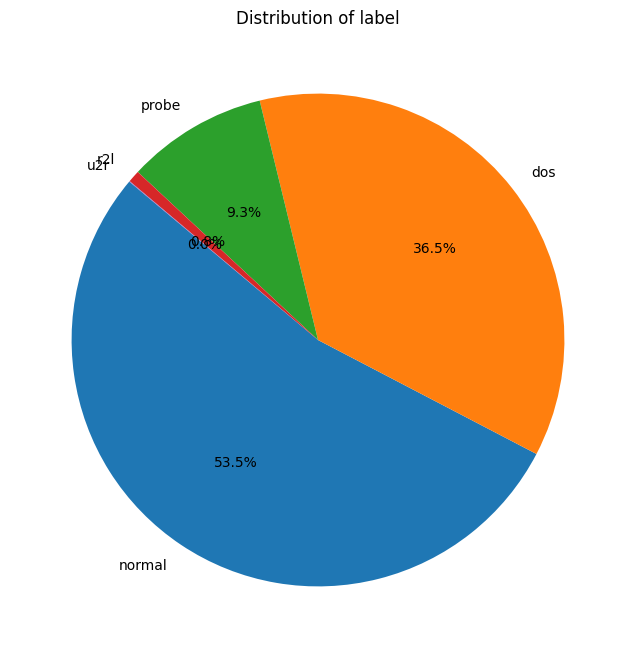

/Users/tarunannapareddy/.local/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tarunannapareddy/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Results for Linear SVC:
F1 Score: 0.6437
Accuracy: 0.6845
G-mean Score: 0.1992

Results for Decision Tree:
F1 Score: 0.7211
Accuracy: 0.7599
G-mean Score: 0.3154

Results for Random Forest:
F1 Score: 0.7112
Accuracy: 0.7606
G-mean Score: 0.0000


In [8]:
main('KDDTrain.CSV', 'KDDTest.CSV')

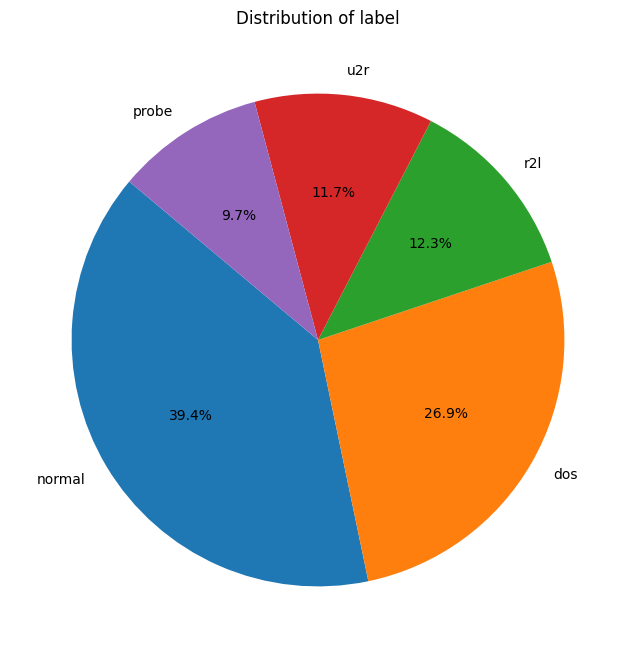

/Users/tarunannapareddy/.local/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tarunannapareddy/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Results for Linear SVC:
F1 Score: 0.6353
Accuracy: 0.6321
G-mean Score: 0.3224

Results for Decision Tree:
F1 Score: 0.5493
Accuracy: 0.4842
G-mean Score: 0.3899

Results for Random Forest:
F1 Score: 0.7663
Accuracy: 0.7740
G-mean Score: 0.5192


In [23]:
main('KDDTrainSynthatic.CSV', 'KDDTest.CSV')